# EDA Capstone Project
Sam's EDA on datasets

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Looking at Demand Dataset
Supplied dataset
- Quick look at seasonality and trends in demand data
- Separating data out into min and max values to see higher level trends

In [96]:
demand_df = pd.read_csv('../data/raw/totaldemand_nsw.csv')
demand_df['DATETIME'] = pd.to_datetime(demand_df['DATETIME'])

In [97]:
demand_df.dtypes

DATETIME       datetime64[ns]
REGIONID               object
TOTALDEMAND           float64
dtype: object

In [98]:
demand_df.head()

,DATETIME,REGIONID,TOTALDEMAND
0,2010-01-01 00:00:00,NSW1,7997.41
1,2010-01-01 00:05:00,NSW1,7946.51
2,2010-01-01 00:10:00,NSW1,7921.55
3,2010-01-01 00:15:00,NSW1,7837.84
4,2010-01-01 00:20:00,NSW1,7781.11


<AxesSubplot:xlabel='DATETIME', ylabel='TOTALDEMAND'>

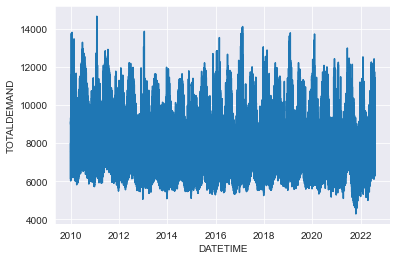

In [99]:
sns.lineplot(data=demand_df, x='DATETIME', y='TOTALDEMAND')

<AxesSubplot:xlabel='DATETIME', ylabel='TOTALDEMAND'>

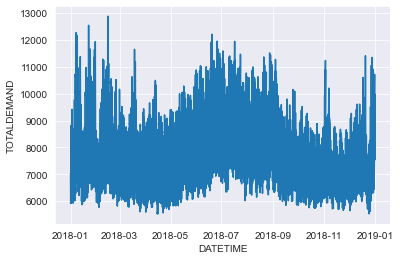

In [100]:
# Zoom in on 2018 data to look at yearly trends
mask = (demand_df.DATETIME >= pd.Timestamp('2018')) & (demand_df.DATETIME < pd.Timestamp('2019'))
sns.lineplot(data=demand_df.loc[mask], x='DATETIME', y='TOTALDEMAND')

<AxesSubplot:xlabel='DATETIME'>

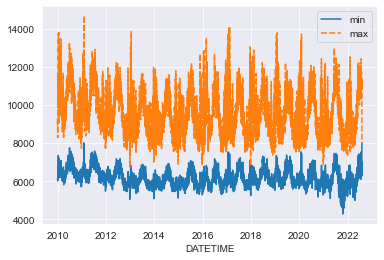

In [101]:
dem_minmax = demand_df.resample('D', on='DATETIME')['TOTALDEMAND'].agg(['min', 'max'])
sns.lineplot(data=dem_minmax)

## Looking at Small-Scale Solar Dataset
Data from Clean Energy Regulator.
- Get data into a more workable format for analysis and modelling
- combine data from all available .xlsx files

In [102]:
solar08_df = pd.read_excel('../data/raw/Postcode data for small-scale installations 2009 - all data.xlsx',
                           sheet_name='SGU-Solar', header=2)

C:\Users\sambo\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [103]:
solar08_df.head()

,Small Unit Installation Postcode,Previous Years (2001-2007) - Installations Quantity,Previous Years (2001-2007) - SGU Rated Output In kW,Jan 2008 - Installations Quantity,Jan 2008 - SGU Rated Output In kW,Feb 2008 - Installations Quantity,Feb 2008 - SGU Rated Output In kW,Mar 2008 - Installations Quantity,Mar 2008 - SGU Rated Output In kW,Apr 2008 - Installations Quantity,...,Sep 2009 - Installations Quantity,Sep 2009 - SGU Rated Output In kW,Oct 2009 - Installations Quantity,Oct 2009 - SGU Rated Output In kW,Nov 2009 - Installations Quantity,Nov 2009 - SGU Rated Output In kW,Dec 2009 - Installations Quantity,Dec 2009 - SGU Rated Output In kW,Installations Quantity Total,SGU Rated Output In kW Total
0,0,4,4.46,0,0.00,0,0.0,0,0.0,0,...,0,0.0,0,0.0,0,0.0,0,0.0,4,4.46
1,200,1,0.08,0,0.00,0,0.0,0,0.0,0,...,0,0.0,0,0.0,0,0.0,0,0.0,1,0.08
2,800,3,19.36,2,4.16,0,0.0,0,0.0,0,...,0,0.0,0,0.0,0,0.0,0,0.0,7,34.74
3,801,2,3.44,0,0.00,0,0.0,0,0.0,0,...,0,0.0,0,0.0,0,0.0,0,0.0,2,3.44
4,803,0,0.00,0,0.00,0,0.0,0,0.0,0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.00


Create a filter for NSW, i.e. 2XXX postcodes

In [104]:
def nsw_mask(df):
    mask = (df['Small Unit Installation Postcode'] >= 2000) & (df['Small Unit Installation Postcode'] < 3000)
    return mask


In [105]:
mask08 = nsw_mask(solar08_df)
nsw08_df = solar08_df.loc[mask08]

Get the initial solar units and output for later when we are looking at the cumulative data

In [106]:
INITIAL_SOLARUNITS = nsw08_df.sum()['Previous Years (2001-2007) - Installations Quantity']
INITIAL_SOLARPOWER = nsw08_df.sum()['Previous Years (2001-2007) - SGU Rated Output In kW']


In [107]:
# Get total number of units added in usable format
solar_units = nsw08_df.filter(regex='2008 - Installations Quantity', axis=1).sum()
solar_units.index = ['Jan 2008', 'Feb 2008', 'Mar 2008', 'Apr 2008', 'May 2008', 'Jun 2008',
                 'Jul 2008', 'Aug 2008', 'Sep 2008', 'Oct 2008', 'Nov 2008', 'Dec 2008']
solar_units.index = pd.to_datetime(solar_units.index)

# Do the same for power added
solar_output = nsw08_df.filter(regex='2008 - SGU Rated Output In kW', axis=1).sum()
solar_output.index = ['Jan 2008', 'Feb 2008', 'Mar 2008', 'Apr 2008', 'May 2008', 'Jun 2008',
                      'Jul 2008', 'Aug 2008', 'Sep 2008', 'Oct 2008', 'Nov 2008', 'Dec 2008']
solar_output.index = pd.to_datetime(solar_output.index)

In [108]:
# Add data from other workbooks
months = ['Jan ', 'Feb ', 'Mar ', 'Apr ', 'May ', 'Jun ',
          'Jul ', 'Aug ', 'Sep ', 'Oct ', 'Nov ', 'Dec ']


for year in range(2009, 2021):
    df = pd.read_excel('../data/raw/Postcode data for small-scale installations ' + str(year) + ' - all data.xlsx',
                    sheet_name=0, header=2)
    # filter by NSW data only
    loc_mask = nsw_mask(df)
    df = df.loc[loc_mask]
    # separate Quantity and Output
    df_units = df.filter(regex= str(year) + ' - Installations Quantity', axis=1).sum()
    df_output = df.filter(regex= str(year) + ' - SGU Rated Output In kW', axis=1).sum()
    # Reset index to datetime
    month_year = []
    for month in months:
        month_year.append(month + str(year))
    df_units.index = month_year
    df_units.index = pd.to_datetime(df_units.index)
    df_output.index = month_year
    df_output.index = pd.to_datetime(df_output.index)
    # Append to end of dataframe
    solar_units = pd.concat([solar_units, df_units])
    solar_output = pd.concat([solar_output, df_output])


C:\Users\sambo\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\sambo\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\sambo\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\sambo\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\sambo\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be igno

<AxesSubplot:>

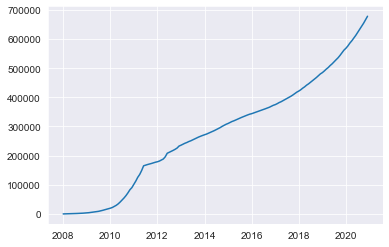

In [109]:
sns.lineplot(data=solar_units.cumsum())

<AxesSubplot:>

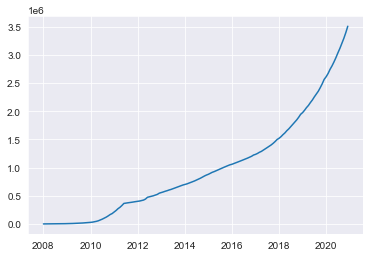

In [110]:
sns.lineplot(data=solar_output.cumsum())

In [111]:
# Build usable dataset for export
cum_solar_units = solar_units.cumsum() + INITIAL_SOLARUNITS
cum_solar_output = solar_output.cumsum() + INITIAL_SOLARPOWER

solar_df = pd.concat([solar_units, cum_solar_units, solar_output, cum_solar_output], axis=1)
solar_df.rename(columns={0:'solar units added', 1:'cumulative units added', 2:'solar output added', 3:'cumulative output added'}, inplace=True)

In [112]:
solar_df

,solar units added,cumulative units added,solar output added,cumulative output added
2008-01-01,127,1882.0,287.946,2710.745
2008-02-01,172,2054.0,258.114,2968.859
2008-03-01,192,2246.0,294.417,3263.276
2008-04-01,183,2429.0,303.252,3566.528
2008-05-01,233,2662.0,339.387,3905.915
...,...,...,...,...
2020-08-01,10063,633994.0,80245.865,3117199.872
2020-09-01,11059,645053.0,90265.829,3207465.701
2020-10-01,10578,655631.0,87108.487,3294574.188
2020-11-01,12191,667822.0,102589.506,3397163.694


In [113]:
solar_df.to_csv('../data/raw/nsw_residential_solar.csv')

## Look At Relationships Between Temperature and Peak/Min Demand
- Using the temperature dataset, total demand dataset
- Will integrate the Rainfall Dataset

In [114]:
temp_df = pd.read_csv('../data/raw/temperature_nsw.csv')
temp_df['LOCATION'].unique()

array([94766.])

In [115]:
temp_df['DATETIME'] = pd.to_datetime(temp_df['DATETIME'])
temp_df.dtypes

DATETIME       datetime64[ns]
LOCATION              float64
TEMPERATURE           float64
dtype: object

In [116]:
temp_df.describe()

,LOCATION,TEMPERATURE
count,247646.0,247646.000000
mean,94766.0,16.518476
std,0.0,87.923650
min,94766.0,-9999.000000
25%,94766.0,13.300000
50%,94766.0,17.600000
75%,94766.0,21.200000
max,94766.0,44.700000


Will need to remove the -9999 values, likely recording/sensor issue

In [117]:
temp_df.drop(temp_df[temp_df['TEMPERATURE'] <= -9999].index, inplace = True)

In [118]:
demand_df.describe()

,TOTALDEMAND
count,1.323398e+06
mean,8.067966e+03
std,1.308206e+03
min,4.286190e+03
25%,7.097480e+03
50%,7.996510e+03
75%,8.914310e+03
max,1.464883e+04


In [119]:
# Check for NaN before merge
print(temp_df.isnull().values.any())
print(demand_df.isnull().values.any())

# Merge data
full_df = demand_df.merge(temp_df, how='outer', on='DATETIME')
print(full_df.isnull().values.any())
full_df

False
False
True


,DATETIME,REGIONID,TOTALDEMAND,LOCATION,TEMPERATURE
0,2010-01-01 00:00:00,NSW1,7997.41,94766.0,23.1
1,2010-01-01 00:05:00,NSW1,7946.51,NaN,NaN
2,2010-01-01 00:10:00,NSW1,7921.55,NaN,NaN
3,2010-01-01 00:15:00,NSW1,7837.84,NaN,NaN
4,2010-01-01 00:20:00,NSW1,7781.11,NaN,NaN
...,...,...,...,...,...
1346187,2022-07-30 22:57:00,NaN,NaN,94766.0,5.2
1346188,2022-07-31 00:24:00,NaN,NaN,94766.0,4.5
1346189,2022-07-31 02:01:00,NaN,NaN,94766.0,3.6
1346190,2022-07-31 02:36:00,NaN,NaN,94766.0,4.1


In [120]:
# Get minimum and maximum values for each day
full_minmax_df = full_df.resample('D', on='DATETIME')['TOTALDEMAND', 'TEMPERATURE'].agg(['min', 'max'])
full_minmax_df.columns = ['demand_min', 'demand_max', 'temp_min', 'temp_max']
full_minmax_df

,demand_min,demand_max,temp_min,temp_max
DATETIME,,,,
2010-01-01,6157.36,8922.42,22.1,28.8
2010-01-02,6112.73,9326.64,21.6,29.4
2010-01-03,6014.91,8277.85,17.9,21.5
2010-01-04,6023.79,9522.30,17.9,23.9
2010-01-05,6287.12,10728.72,15.4,27.7
...,...,...,...,...
2022-07-28,6890.27,10799.70,3.8,19.5
2022-07-29,6890.30,11393.11,7.1,16.1
2022-07-30,6269.02,11013.55,2.2,16.8


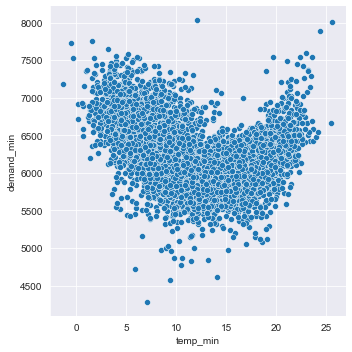

In [121]:
sns.relplot(data=full_minmax_df, x='temp_min', y='demand_min')

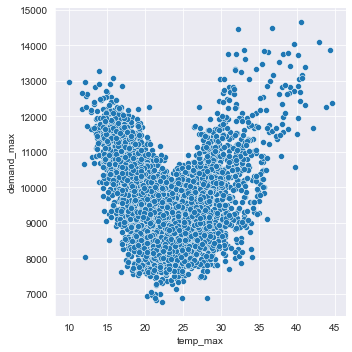

In [122]:
sns.relplot(data=full_minmax_df, x='temp_max', y='demand_max')

Add in Sydney rainfall data to see effects on demand

In [123]:
rain_df = pd.read_csv('../data/raw/sydneybotanic_dailyRainfall.csv')
rain_df.head()

,Product code,Bureau of Meteorology station number,Year,Month,Day,Rainfall amount (millimetres),Period over which rainfall was measured (days),Quality
0,IDCJAC0009,66006,1885,1,1,0.0,NaN,Y
1,IDCJAC0009,66006,1885,1,2,0.0,NaN,Y
2,IDCJAC0009,66006,1885,1,3,3.6,1.0,Y
3,IDCJAC0009,66006,1885,1,4,0.0,NaN,Y
4,IDCJAC0009,66006,1885,1,5,0.0,NaN,Y


In [124]:
# Remove unnecessary columns and data
rain_df['DATETIME'] = pd.to_datetime(rain_df[['Year', 'Month', 'Day']])
rain_df.drop(['Product code', 'Bureau of Meteorology station number', 'Period over which rainfall was measured (days)',
              'Quality', 'Year', 'Month', 'Day'], axis=1, inplace=True)
rain_df.head()

,Rainfall amount (millimetres),DATETIME
0,0.0,1885-01-01
1,0.0,1885-01-02
2,3.6,1885-01-03
3,0.0,1885-01-04
4,0.0,1885-01-05


In [125]:
# Merge with existing data
full_minmax_df = full_minmax_df.merge(rain_df, how='left', on='DATETIME')

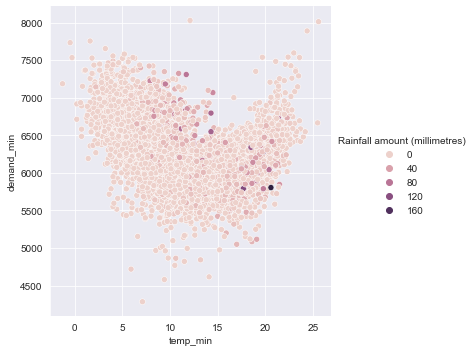

In [126]:
sns.relplot(data=full_minmax_df, x='temp_min', y='demand_min', hue='Rainfall amount (millimetres)')

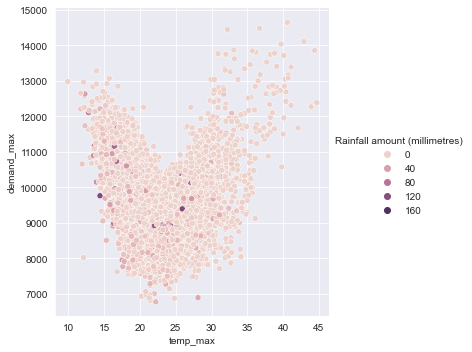

In [127]:
sns.relplot(data=full_minmax_df, x='temp_max', y='demand_max', hue='Rainfall amount (millimetres)')

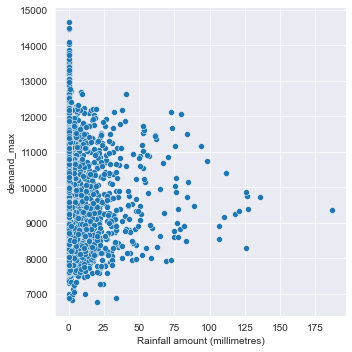

In [128]:
sns.relplot(data=full_minmax_df, x='Rainfall amount (millimetres)', y='demand_max')

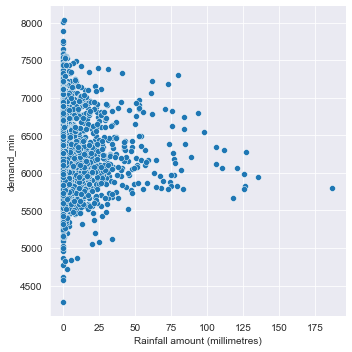

In [129]:
sns.relplot(data=full_minmax_df, x='Rainfall amount (millimetres)', y='demand_min')

Looks like total rainfall from one location in Sydney is not very useful as a predictor for demand. Maybe adding more locations could be helpfull in the modelling step.
It's possible that using just one location to represent the whole state for rainfall/cloudcover is not as useful as temperature.